In [2]:
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import PIL

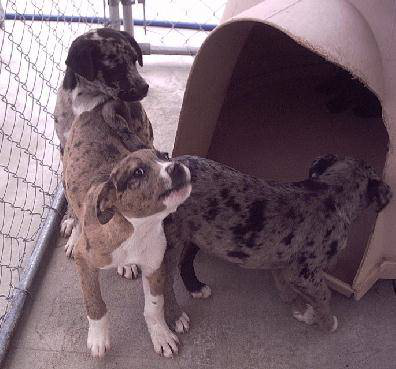

In [106]:
PATH = 'data/cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

# Variables for pre-processing and training.
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

# Explore data
train_dir = pathlib.Path(train_dir)
dogs_train = list(train_dir.glob('dogs/*'))
PIL.Image.open(str(dogs_train[1]))

In [107]:
train_image_generator = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=90)
validation_image_generator = ImageDataGenerator(rescale=1./255)
test_image_generator = ImageDataGenerator(rescale=1./255)

train_data_gen = train_image_generator.flow_from_directory(
    batch_size=batch_size, 
    directory=train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary'
)
val_data_gen = validation_image_generator.flow_from_directory(
    batch_size=batch_size, 
    directory=validation_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary')
test_data_gen = test_image_generator.flow_from_directory(
    batch_size=batch_size, 
    directory=PATH,
    classes=['test'],
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode=None,
    shuffle=False)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 images belonging to 1 classes.


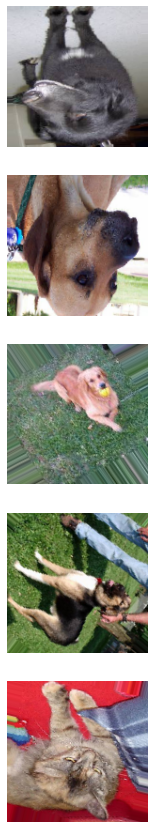

In [22]:
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
    else:
      for img, probability, ax in zip( images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
          if probability > 0.5:
              ax.set_title("%.2f" % (probability*100) + "% dog")
          else:
              ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
    plt.show()

sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])

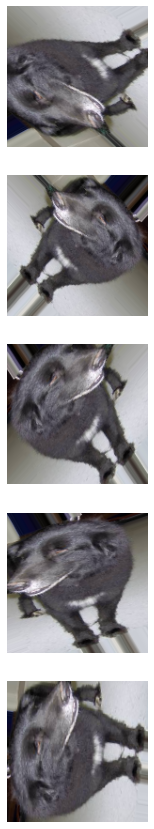

In [23]:
# Plot the same image to see transformations
augmented_images = [train_data_gen[0][0][0] for i in range(5)]

plotImages(augmented_images)

In [24]:
# Create model and compile
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(150, 150, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(10))

model.summary()

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        36928     
_________________________________________________________________
flatten (Flatten)            (None, 73984)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                4

In [25]:
# Train model on train dataset and validate with validation dataset
history = model.fit(train_data_gen, steps_per_epoch=10,  epochs=10,
                    validation_data=val_data_gen, validation_steps=20)

Epoch 1/10
10/10 [==============================] - 9s 883ms/step - loss: 1.6698 - accuracy: 0.4344 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 2/10
10/10 [==============================] - 8s 846ms/step - loss: 0.6931 - accuracy: 0.4625 - val_loss: 0.6931 - val_accuracy: 0.4922
Epoch 3/10
10/10 [==============================] - 8s 789ms/step - loss: 0.6931 - accuracy: 0.4719 - val_loss: 0.6931 - val_accuracy: 0.4812
Epoch 4/10
10/10 [==============================] - 9s 867ms/step - loss: 0.6931 - accuracy: 0.4781 - val_loss: 0.6931 - val_accuracy: 0.4891
Epoch 5/10
10/10 [==============================] - 9s 857ms/step - loss: 0.6931 - accuracy: 0.4656 - val_loss: 0.6931 - val_accuracy: 0.4953
Epoch 6/10
10/10 [==============================] - 8s 793ms/step - loss: 0.6931 - accuracy: 0.4969 - val_loss: 0.6931 - val_accuracy: 0.5016
Epoch 7/10
10/10 [==============================] - 8s 816ms/step - loss: 0.6931 - accuracy: 0.5469 - val_loss: 0.6931 - val_accuracy: 0.5141
Epoch 

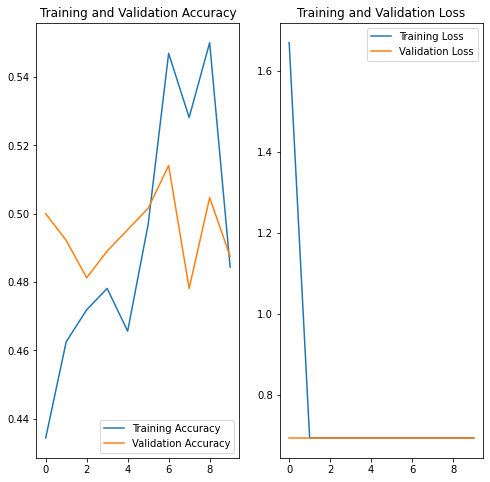

In [26]:
# Plot loss and acc curves
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = 10
epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()